<h1><center> IBM® LinuxONE Data and AI: Credit Default Risk Analysis using scikit-learn </center></h1>

Financial organizations around the world face the constant challenge to accurately predict the risk of credit default. This covers all aspects of financial lending, including personal, corporate and public finance. To enhance and automate this process, great interest has been placed on the usage of data science and machine learning to predict the customers most likely to default. These lending processes mainly run on an institution's core business systems, with IBM Z and LinuxONE providing the industry standard platform for security, resiliency and scalability. With Anaconda on IBM Z and LinuxONE a customer can run their machine learning model co-located to their key processes, without the need to move data off the platform, ensuring security and data currency. To that end, we have created an example credit default model leveraging python and conda with Linux on Z.

In this example we will train a Logistic Regression model on customers' credit history dataset using scikit-learn.

NOTE: This notebook is a based on the original notebook available at https://github.com/ibmsoe/snap-ml/blob/master/notebooks/credit-default-prediction-example.ipynb

In [1]:
#Installation instructions for Anaconda on Linux on Z and LinuxONE can be found here: https://docs.anaconda.com/anaconda/install/linux-s390x/

### Download dataset that has the customer information

The dataset contains 10 million transactions with 19 variables.

You can comment out the downloading code below if running the same wget command more than once.

In [2]:
# Download dataset csv file
#!wget -O credit_customer_history.csv -nc https://ibm.box.com/shared/static/c84jns0hy2ty05t3c3a9c17ca1mxpe6s.csv

In [3]:
!uname -om

s390x GNU/Linux


### Install the necessary conda packages 

In [4]:
#!conda install -y scikit-learn pandas matplotlib seaborn

### Import statements for data science and related packages 

In [5]:
from __future__ import print_function
import numpy as np   # multi-dimensional arrays , matrices , linear algebra and others
import pandas as pd  # data manipulation and analysis
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt # static, animated, and interactive data visualizations 
%matplotlib inline
import sklearn        # Data preparation, train and score
import seaborn as sns # Data visualization library for statistical graphics plotting
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score
from scipy.stats import chi2_contingency,ttest_ind
from sklearn.utils import shuffle
import time

import warnings
warnings.filterwarnings('ignore')


In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

## Exploratory Data Analysis (EDA)


As part of the EDA we will conduct the following exploration below:  
1) We would like to see if there are any null values present in the dataset to ensure no imputation. 
2) Our target varible is IS_DEFAULT, and we would like to understand its distribution. 
3) Then we will look into the distribution of a few select features and their relationship to the target varaible.


Let's take a quick look at the dataset

In [7]:
cust_pd_full = pd.read_csv('credit_customer_history.csv')

#Taking only 1 Million records for EDA.
rows=1000000
cust_pd = cust_pd_full.head(rows)
print("There are " + str(len(cust_pd_full)) + " observations in the customer history dataset.")
print("There are " + str(len(cust_pd_full.columns)) + " variables in the dataset.")

cust_pd.head()

There are 10000000 observations in the customer history dataset.
There are 19 variables in the dataset.


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL,IS_DEFAULT
0,77,EXISTING CREDITS PAID BACK,EDUCATION,27630,UNKNOWN/NONE,above 7 YRS,CT,NO,YES,YES,YES,NO,YES,NO,0,4,NO,NO,No
1,119,EXISTING CREDITS PAID BACK,ELECTRONICS,31314,above 1000 K USD,4 to 7 YRS,CT,YES,YES,YES,YES,NO,NO,YES,0,3,YES,YES,No
2,84,EXISTING CREDITS PAID BACK,FURNITURE,27630,above 1000 K USD,4 to 7 YRS,PA,NO,NO,YES,YES,YES,NO,YES,0,3,YES,YES,No
3,119,DELAY IN PAST,FURNITURE,33156,above 1000 K USD,up to 1 YR,PA,YES,NO,YES,NO,NO,NO,YES,0,3,NO,NO,Yes
4,105,DELAY IN PAST,FURNITURE,23946,above 1000 K USD,up to 1 YR,CT,NO,YES,YES,YES,YES,YES,NO,0,3,YES,YES,No


In [8]:
#the datatype of the features
cust_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   EMI_TENURE             1000000 non-null  int64 
 1   CREDIT_HISTORY         1000000 non-null  object
 2   TRANSACTION_CATEGORY   1000000 non-null  object
 3   TRANSACTION_AMOUNT     1000000 non-null  int64 
 4   ACCOUNT_TYPE           1000000 non-null  object
 5   ACCOUNT_AGE            1000000 non-null  object
 6   STATE                  1000000 non-null  object
 7   IS_URBAN               1000000 non-null  object
 8   IS_STATE_BORDER        1000000 non-null  object
 9   HAS_CO_APPLICANT       1000000 non-null  object
 10  HAS_GUARANTOR          1000000 non-null  object
 11  OWN_REAL_ESTATE        1000000 non-null  object
 12  OTHER_INSTALMENT_PLAN  1000000 non-null  object
 13  OWN_RESIDENCE          1000000 non-null  object
 14  NUMBER_CREDITS         1000000 non-

Let us see if there are any missing values in the dataset 

In [9]:
cust_pd.isnull().sum()

EMI_TENURE               0
CREDIT_HISTORY           0
TRANSACTION_CATEGORY     0
TRANSACTION_AMOUNT       0
ACCOUNT_TYPE             0
ACCOUNT_AGE              0
STATE                    0
IS_URBAN                 0
IS_STATE_BORDER          0
HAS_CO_APPLICANT         0
HAS_GUARANTOR            0
OWN_REAL_ESTATE          0
OTHER_INSTALMENT_PLAN    0
OWN_RESIDENCE            0
NUMBER_CREDITS           0
RFM_SCORE                0
OWN_CAR                  0
SHIP_INTERNATIONAL       0
IS_DEFAULT               0
dtype: int64

Since there are no missing values in the dataset, let's move forward with dataset visualization. 

### Distribution of the Target variable (IS_DEFAULT) 
Create visuals to understand the percentage of accounts in default.   

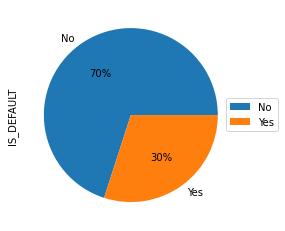

In [10]:
#Pie chart to show the percentage of accounts in default
cust_pd.IS_DEFAULT.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.6))

In the dataset 70% of accounts are in good standing, while 30% are in default. 

### Default by Credit Program (TRANSACTION_CATEGORY)

As part of the EDA, we will examine the types of credit programs in the dataset, and conduct a comparative study of their individual default rates. 

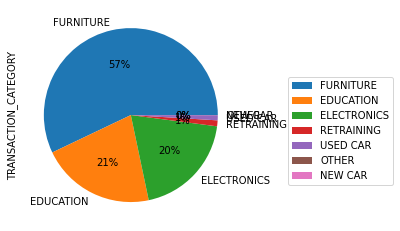

In [11]:
# Pie chart to show the percentage of accounts by Credit Program (TRANSACTION_CATEGORY)
cust_pd.TRANSACTION_CATEGORY.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.7))

The top three credit programs with most customers are Furniture (57%), Education (21%) and Electronics (20%).

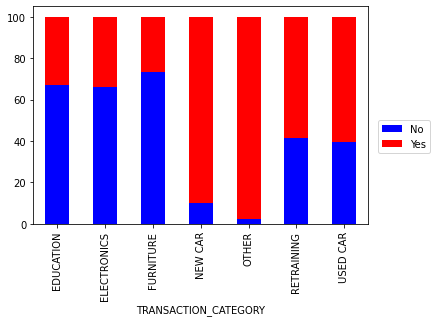

In [12]:
#Create a bar chart to show the default rates by Credit Program (TRANSACTION_CATEGORY)
defaults_by_credit_program = cust_pd.groupby(['TRANSACTION_CATEGORY','IS_DEFAULT']).size()
percentages = defaults_by_credit_program.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(bbox_to_anchor=(1.2, 0.5))

The top three credit programs with the highest default rate are New Car(89.7%), Used Car(60.6%) and Retraining(58.5%). However, all undeclared credit programs by the lendees belong to `OTHER` category in the dataset.  


### Default by State Border

In case IS_STATE_BORDER is set to YES, accounts/businesses are expanded to multiple states. It also signifies the scale of the business, assuming that mulit-state businesses are larger.  

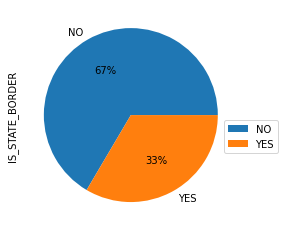

In [13]:
# Pie chart to show percentage of businesses in single vs multiple states
cust_pd.IS_STATE_BORDER.value_counts().plot(kind='pie',autopct='%1.0f%%').legend(bbox_to_anchor=(1.2, 0.5))

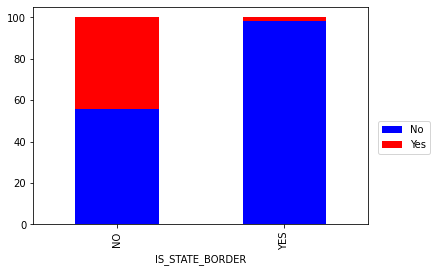

In [14]:
#Bar chart to compare default rates based on if an account expands across state borders
defaults_by_xborder = cust_pd.groupby(['IS_STATE_BORDER','IS_DEFAULT']).size()
percentages = defaults_by_xborder.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,  color=['blue','red'], grid=False).legend(bbox_to_anchor=(1.2, 0.5))

Fromt the visual above, we can infer that the larger scale businesses have a lower chance of default. 

### Will a customer still default with a co-applicant? 
Examination on the effects on default of having a co-applicant

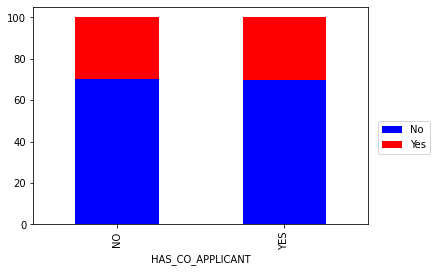

In [15]:
#Bar chart looking at the default rates when having and not having a co-applicant
defaults_by_co_applicant = cust_pd.groupby(['HAS_CO_APPLICANT','IS_DEFAULT']).size()
percentages = defaults_by_co_applicant.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,  color=['blue','red'], grid=False).legend(bbox_to_anchor=(1.2, 0.5))

From bar chart above we can see that HAS_CO_APPLICANT feature has negligible impact on the default rate.  

### Does credit history play a role in the default rate?

Examination into the impact of a customer's credit history on the default rate. 

<AxesSubplot:title={'center':'CREDIT_HISTORY'}>

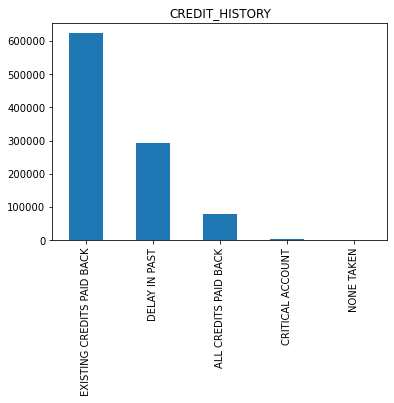

In [16]:
# Bar chart of the types of credit history for each account, based on prior payment history
cust_pd.CREDIT_HISTORY.value_counts().plot(kind='bar', title='CREDIT_HISTORY')

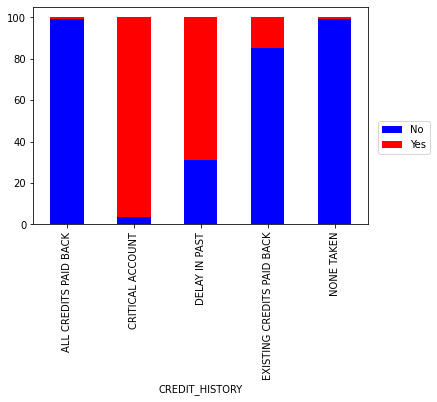

In [17]:
# Stack bar chart showing the current default percentages for accounts based on their past payment history
defaults_by_history = cust_pd.groupby(['CREDIT_HISTORY','IS_DEFAULT']).size()
percentages = defaults_by_history.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
percentages.unstack().plot(kind='bar',stacked=True,color=['blue','red'],grid=False).legend(bbox_to_anchor=(1.2, 0.5))

From the visual above we observe that lendees with prior payment problems have a higher likelihood of default, as well as those who are labeled critical accounts.  

### Numerical features - EMI_TENURE, TRANSACTION_AMOUNT, NUMBER_CREDITS, RFM_SCORE

The dataset has more categorical features than numerical ones overall as seen above. Below we will visualize the numerical variables and find out the meaning and relationships of the features, such as - EMI_TENURE, TRANSACTION_AMOUNT, NUMBER_CREDITS, RFM_SCORE, with the Target Variable (IS_DEFAULT). 

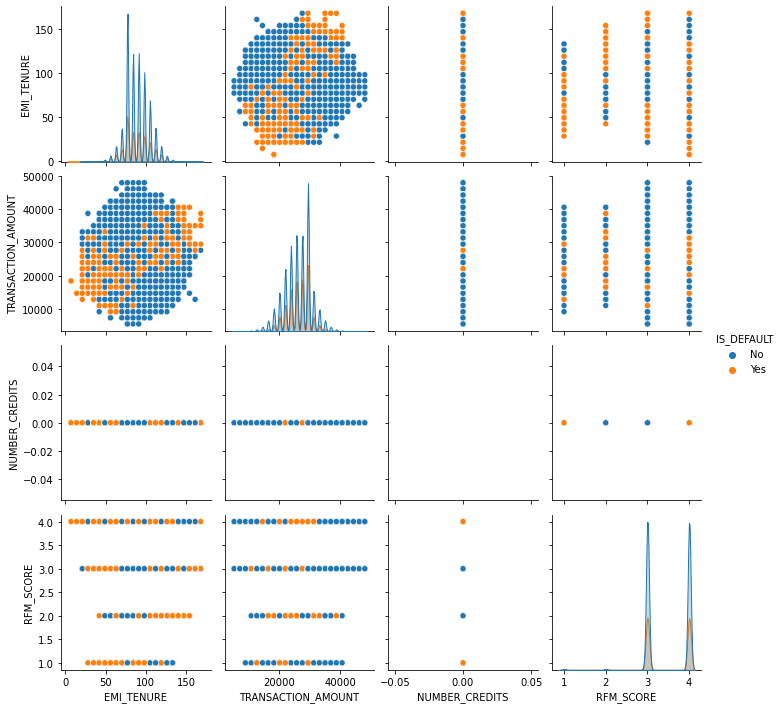

In [18]:
# Create a pair plot of numerical variables with the default variable
sns.pairplot(cust_pd, hue="IS_DEFAULT")

* `pairplot` is a useful method to identify trends for further analysis. It appears that higher EMI_TENURE slightly increases the chances of default.  EMI stands for equated monthy installement.

## Data preparation

In this section, we will get the data ready for training and evaluating the model by transforming features using popular techniques such as normalization, one-hot encoding, label encoding etc. 

In [19]:
# Quick preview of the dataset
cust_pd = cust_pd_full
cust_pd.head()


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL,IS_DEFAULT
0,77,EXISTING CREDITS PAID BACK,EDUCATION,27630,UNKNOWN/NONE,above 7 YRS,CT,NO,YES,YES,YES,NO,YES,NO,0,4,NO,NO,No
1,119,EXISTING CREDITS PAID BACK,ELECTRONICS,31314,above 1000 K USD,4 to 7 YRS,CT,YES,YES,YES,YES,NO,NO,YES,0,3,YES,YES,No
2,84,EXISTING CREDITS PAID BACK,FURNITURE,27630,above 1000 K USD,4 to 7 YRS,PA,NO,NO,YES,YES,YES,NO,YES,0,3,YES,YES,No
3,119,DELAY IN PAST,FURNITURE,33156,above 1000 K USD,up to 1 YR,PA,YES,NO,YES,NO,NO,NO,YES,0,3,NO,NO,Yes
4,105,DELAY IN PAST,FURNITURE,23946,above 1000 K USD,up to 1 YR,CT,NO,YES,YES,YES,YES,YES,NO,0,3,YES,YES,No


### Split dataframe into Features and Labels
Now we divide the cust_pd dataframe into cust_pd_X (features) and cust_pd_Y (labels)

In [20]:
# Spit the dataset into features and labels
#Labels
cust_pd_Y = cust_pd[['IS_DEFAULT']]
#Features
cust_pd_X = cust_pd.drop(['IS_DEFAULT'],axis=1)

#See the shape of the Features and Labels
print('cust_pd_X.shape=', cust_pd_X.shape, 'cust_pd_Y.shape=', cust_pd_Y.shape)


cust_pd_X.shape= (10000000, 18) cust_pd_Y.shape= (10000000, 1)


### Transform Label

Since the labels will be used during the training of the model, we need to transform categorical labels into numerical labels.   

In [21]:
# Preview the labels
cust_pd_Y.head()

,IS_DEFAULT
0,No
1,No
2,No
3,Yes
4,No


In [22]:
#`LabelEncoder` transformer will be used to encode the target labels below. 
le = LabelEncoder()
cust_pd_Y['IS_DEFAULT'] = le.fit_transform(cust_pd_Y['IS_DEFAULT'])
cust_pd_Y.head()

,IS_DEFAULT
0,0
1,0
2,0
3,1
4,0


### Transform Features
Transform the features to be used in the model training. 

EMI_TENURE, NUMBER_CREDITS, TRANSACTION_AMOUNT, CREDIT_HISTORY_ALL CREDITS PAID BACK, CREDIT_HISTORY_CRITICAL ACCOUNT, CREDIT_HISTORY_DELAY IN PAST, CREDIT_HISTORY_EXISTING CREDITS PAID BACK, CREDIT_HISTORY_NONE TAKEN etc are some of the features which are being used here for the training and inferencing.

In [23]:
# View of the features
print('features df shape = ', cust_pd_X.shape)
cust_pd_X.head()

features df shape =  (10000000, 18)


,EMI_TENURE,CREDIT_HISTORY,TRANSACTION_CATEGORY,TRANSACTION_AMOUNT,ACCOUNT_TYPE,ACCOUNT_AGE,STATE,IS_URBAN,IS_STATE_BORDER,HAS_CO_APPLICANT,HAS_GUARANTOR,OWN_REAL_ESTATE,OTHER_INSTALMENT_PLAN,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,OWN_CAR,SHIP_INTERNATIONAL
0,77,EXISTING CREDITS PAID BACK,EDUCATION,27630,UNKNOWN/NONE,above 7 YRS,CT,NO,YES,YES,YES,NO,YES,NO,0,4,NO,NO
1,119,EXISTING CREDITS PAID BACK,ELECTRONICS,31314,above 1000 K USD,4 to 7 YRS,CT,YES,YES,YES,YES,NO,NO,YES,0,3,YES,YES
2,84,EXISTING CREDITS PAID BACK,FURNITURE,27630,above 1000 K USD,4 to 7 YRS,PA,NO,NO,YES,YES,YES,NO,YES,0,3,YES,YES
3,119,DELAY IN PAST,FURNITURE,33156,above 1000 K USD,up to 1 YR,PA,YES,NO,YES,NO,NO,NO,YES,0,3,NO,NO
4,105,DELAY IN PAST,FURNITURE,23946,above 1000 K USD,up to 1 YR,CT,NO,YES,YES,YES,YES,YES,NO,0,3,YES,YES


### One-hot encoding for categorical columns
Categorical variables will be represented as binary vectors using One-hot encoding. 

In [24]:
# One-hot encoding
categoricalColumns = ['CREDIT_HISTORY', 'TRANSACTION_CATEGORY', 'ACCOUNT_TYPE', 'ACCOUNT_AGE',
                      'STATE', 'IS_URBAN', 'IS_STATE_BORDER', 'HAS_CO_APPLICANT', 'HAS_GUARANTOR',
                      'OWN_REAL_ESTATE', 'OTHER_INSTALMENT_PLAN',
                      'OWN_RESIDENCE', 'RFM_SCORE', 'OWN_CAR', 'SHIP_INTERNATIONAL']
cust_pd_X = pd.get_dummies(cust_pd_X, columns=categoricalColumns)

cust_pd_X.head()

,EMI_TENURE,TRANSACTION_AMOUNT,NUMBER_CREDITS,CREDIT_HISTORY_ALL CREDITS PAID BACK,CREDIT_HISTORY_CRITICAL ACCOUNT,CREDIT_HISTORY_DELAY IN PAST,CREDIT_HISTORY_EXISTING CREDITS PAID BACK,CREDIT_HISTORY_NONE TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED CAR,ACCOUNT_TYPE_100 to 500 K USD,ACCOUNT_TYPE_500 to 1000 K USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above 1000 K USD,ACCOUNT_TYPE_up to 100 K USD,ACCOUNT_AGE_1 to 4 YRS,ACCOUNT_AGE_4 to 7 YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above 7 YRS,ACCOUNT_AGE_up to 1 YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES
0,77,27630,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,1,1,0,1,0
1,119,31314,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,0,1
2,84,27630,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1
3,119,33156,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0
4,105,23946,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1


### Normalize Features

Feature scaling is the one of the essential steps to build the best performing machine learning models. Here we are scaling the features using the normalization technique. Normalization helps to scale the features between 0 to 1.  

In [25]:
# Normalize the variables
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(cust_pd_X)
features = normalize(features, axis=1, norm='l1')

cust_pd_X = pd.DataFrame(features,columns=cust_pd_X.columns)
cust_pd_X.head()

,EMI_TENURE,TRANSACTION_AMOUNT,NUMBER_CREDITS,CREDIT_HISTORY_ALL CREDITS PAID BACK,CREDIT_HISTORY_CRITICAL ACCOUNT,CREDIT_HISTORY_DELAY IN PAST,CREDIT_HISTORY_EXISTING CREDITS PAID BACK,CREDIT_HISTORY_NONE TAKEN,TRANSACTION_CATEGORY_EDUCATION,TRANSACTION_CATEGORY_ELECTRONICS,TRANSACTION_CATEGORY_FURNITURE,TRANSACTION_CATEGORY_NEW CAR,TRANSACTION_CATEGORY_OTHER,TRANSACTION_CATEGORY_RETRAINING,TRANSACTION_CATEGORY_USED CAR,ACCOUNT_TYPE_100 to 500 K USD,ACCOUNT_TYPE_500 to 1000 K USD,ACCOUNT_TYPE_UNKNOWN/NONE,ACCOUNT_TYPE_above 1000 K USD,ACCOUNT_TYPE_up to 100 K USD,ACCOUNT_AGE_1 to 4 YRS,ACCOUNT_AGE_4 to 7 YRS,ACCOUNT_AGE_TBD,ACCOUNT_AGE_above 7 YRS,ACCOUNT_AGE_up to 1 YR,STATE_CT,STATE_NJ,STATE_NY,STATE_PA,IS_URBAN_NO,IS_URBAN_YES,IS_STATE_BORDER_NO,IS_STATE_BORDER_YES,HAS_CO_APPLICANT_NO,HAS_CO_APPLICANT_YES,HAS_GUARANTOR_NO,HAS_GUARANTOR_YES,OWN_REAL_ESTATE_NO,OWN_REAL_ESTATE_YES,OTHER_INSTALMENT_PLAN_NO,OTHER_INSTALMENT_PLAN_YES,OWN_RESIDENCE_NO,OWN_RESIDENCE_YES,RFM_SCORE_1,RFM_SCORE_2,RFM_SCORE_3,RFM_SCORE_4,OWN_CAR_NO,OWN_CAR_YES,SHIP_INTERNATIONAL_NO,SHIP_INTERNATIONAL_YES
0,0.027542,0.033533,0.0,0.0,0.0,0.000000,0.062595,0.0,0.062595,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062595,0.000000,0.0,0.0,0.000000,0.0,0.062595,0.000000,0.062595,0.0,0.0,0.000000,0.062595,0.000000,0.000000,0.062595,0.0,0.062595,0.000000,0.062595,0.062595,0.000000,0.000000,0.062595,0.062595,0.000000,0.0,0.0,0.000000,0.062595,0.062595,0.000000,0.062595,0.000000
1,0.041751,0.037277,0.0,0.0,0.0,0.000000,0.061398,0.0,0.000000,0.061398,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.061398,0.0,0.0,0.061398,0.0,0.000000,0.000000,0.061398,0.0,0.0,0.000000,0.000000,0.061398,0.000000,0.061398,0.0,0.061398,0.000000,0.061398,0.061398,0.000000,0.061398,0.000000,0.000000,0.061398,0.0,0.0,0.061398,0.000000,0.000000,0.061398,0.000000,0.061398
2,0.029971,0.033449,0.0,0.0,0.0,0.000000,0.062439,0.0,0.000000,0.000000,0.062439,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062439,0.0,0.0,0.062439,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.062439,0.062439,0.000000,0.062439,0.000000,0.0,0.062439,0.000000,0.062439,0.000000,0.062439,0.062439,0.000000,0.000000,0.062439,0.0,0.0,0.062439,0.000000,0.000000,0.062439,0.000000,0.062439
3,0.041659,0.039384,0.0,0.0,0.0,0.061264,0.000000,0.0,0.000000,0.000000,0.061264,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.061264,0.0,0.0,0.000000,0.0,0.000000,0.061264,0.000000,0.0,0.0,0.061264,0.000000,0.061264,0.061264,0.000000,0.0,0.061264,0.061264,0.000000,0.061264,0.000000,0.061264,0.000000,0.000000,0.061264,0.0,0.0,0.061264,0.000000,0.061264,0.000000,0.061264,0.000000
4,0.037350,0.028902,0.0,0.0,0.0,0.062250,0.000000,0.0,0.000000,0.000000,0.062250,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.062250,0.0,0.0,0.000000,0.0,0.000000,0.062250,0.062250,0.0,0.0,0.000000,0.062250,0.000000,0.000000,0.062250,0.0,0.062250,0.000000,0.062250,0.000000,0.062250,0.000000,0.062250,0.062250,0.000000,0.0,0.0,0.062250,0.000000,0.000000,0.062250,0.000000,0.062250


### Split training dataset

We are splitting the dataset with 70:30 ratio for training and evaluating the model. 

In [26]:
# Split the dataset
label    = cust_pd_Y.values
features  = cust_pd_X.values

label = np.reshape(label,(-1,1))
X_train,X_test,y_train,y_test = \
       train_test_split(features, label, test_size=0.3, random_state=42, stratify=label)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)




X_train.shape= (7000000, 51) Y_train.shape= (7000000, 1)
X_test.shape= (3000000, 51) Y_test.shape= (3000000, 1)


### Train using sklearn
Now we will train our model using the `LogisticRegression` model for the classification problem.

In [27]:
# Create a new Logistic regression classifier object using LogisticRegression() from sklearn 
from sklearn.linear_model import LogisticRegression
sklearn_lr = LogisticRegression()

In [28]:
# Training the LogisticRegression model
sklearn_lr.fit(X_train, y_train)

LogisticRegression()

### Inferencing and Evaluating the model
For evaluating the model, we have chosen `accuracy_score` metric here.

In [29]:
# Inference and check the model accuracy
sklearn_prediction = sklearn_lr.predict(X_test)
print('sklearn ml accuracy score = ', accuracy_score(y_test, sklearn_prediction))

sklearn ml accuracy score =  0.9597963333333334


Since the model achieves a reasonable accuracy score, it can be deployed in a production like or test environment for further validation. 

## Conclusion:

Building a machine learning pipeline on IBM Z and LinuxONE is a seamless experience with the availability of the conda packages required for data visualizations, data preparation, training, evaluating the model and inferencing. To leverage Anaconda packages further on IBM Z and LinuxONE the installation guide can be found [here](https://docs.anaconda.com/anaconda/install/linux-s390x/)

&copy; Copyright IBM Corporation 2018, 2021